Seeing what I can learn looking at the phoenix models and the stis nuv spectra

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
# import stistools
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
from scipy.io.idl import readsav
from astropy.convolution import convolve_fft
from astropy.convolution import Gaussian1DKernel
from matplotlib.gridspec import GridSpec

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [3]:
path = '/media/david/1tb_storage1/emergency_data/mega_muscles/hlsp/'
stars = ['L-980-5',
        'GJ674', 
        'GJ676A',
        'GJ649',
        'GJ699',
        'GJ163',
        'GJ849',
        'GJ1132',
        'LHS-2686',
        'GJ729',
        'GJ15A']


In [27]:
def remove_negatives(w, f, e):
    print(len(f))
    wo, fo, eo = w, f, e
    nz = len(fo[fo <=0.0])
    print(nz)
    while nz > 0:
        fn = []
        wn = []
        en = []
        inds = []
        for i in range(len(fo))[1:-1]:
            if fo[i] <= 0.0:
                inds.append(i-1)
                inds.append(i+1)
                weights = 1 / (eo[i-1:i+2]**2)
                fn.append(np.average(fo[i-1:i+2],weights=weights))
                wn.append(np.mean(wo[i-1:i+2]))
                en.append((1 / np.sum(weights, axis=0))**0.5)
            else:
                wn.append(wo[i])
                fn.append(fo[i])
                en.append(eo[i])
        inds = np.unique(inds)
        wn, fn, en = np.array(wn), np.array(fn), np.array(en)
#         print(len(fn))
        wn, fn, en  = np.delete(wn, inds), np.delete(fn, inds), np.delete(en, inds)
        print(len(fn))
        nz = len(fn[fn <=0.0])
        wo, fo, eo =wn, fn, en
        print(nz)
    return(wn, fn, en)

def smear(w,f, R, w_sample=1):
    '''
    Smears a model spectrum with a gaussian kernel to the given resolution, R.
    Adapeted from https://github.com/spacetelescope/pysynphot/issues/78

    Parameters
    -----------

    w,f:  spectrum to smear

    R: int
        The resolution (dL/L) to smear to

    w_sample: int
        Oversampling factor for smoothing

    Returns
    -----------

    sp: PySynphot Source Spectrum
        The smeared spectrum
    '''

    # Save original wavelength grid and units
    w_grid = w
    

    # Generate logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid)*w_sample
    w_log = np.logspace(w_logmin, w_logmax, num=n_w)

    # Find stddev of Gaussian kernel for smoothing
    R_grid = (w_log[1:-1]+w_log[0:-2])/(w_log[1:-1]-w_log[0:-2])/2
    sigma = np.median(R_grid)/R
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(w_log, w_grid, f)

    # Smooth convolving with Gaussian kernel
    gauss = Gaussian1DKernel(stddev=sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)

    # Write smoothed spectrum back into Spectrum object
    return w_grid, f_sm

L-980-5
744
158
473
0


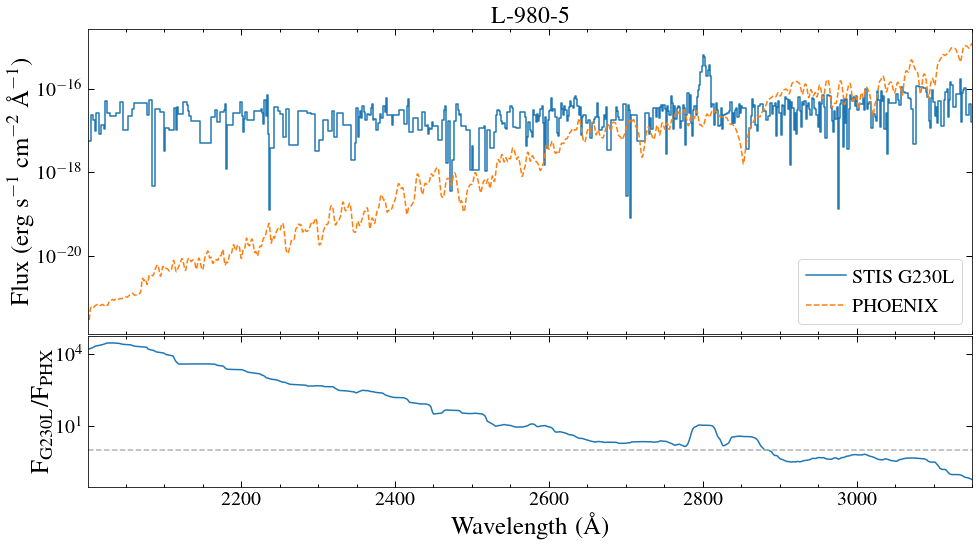

GJ674
745
63
634
0


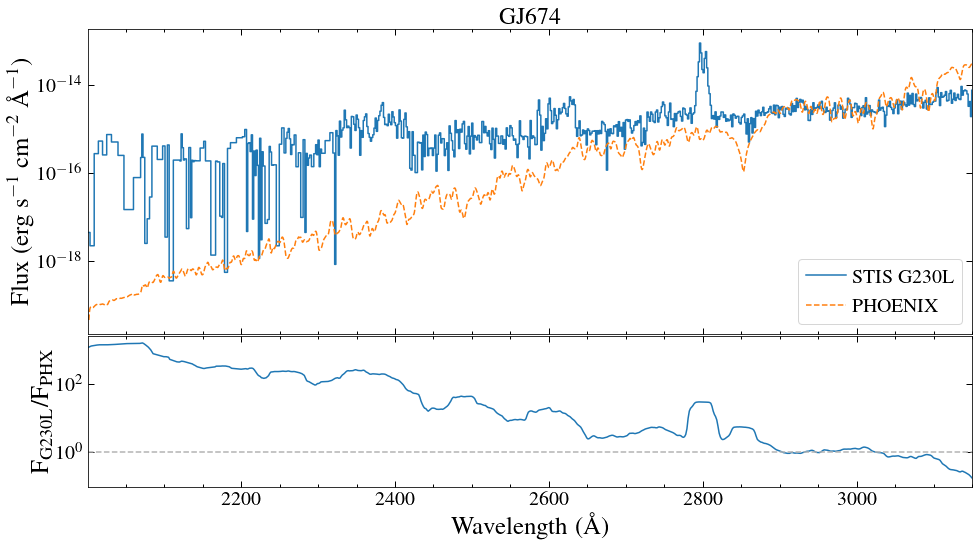

GJ676A
741
1


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:26: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


739
0


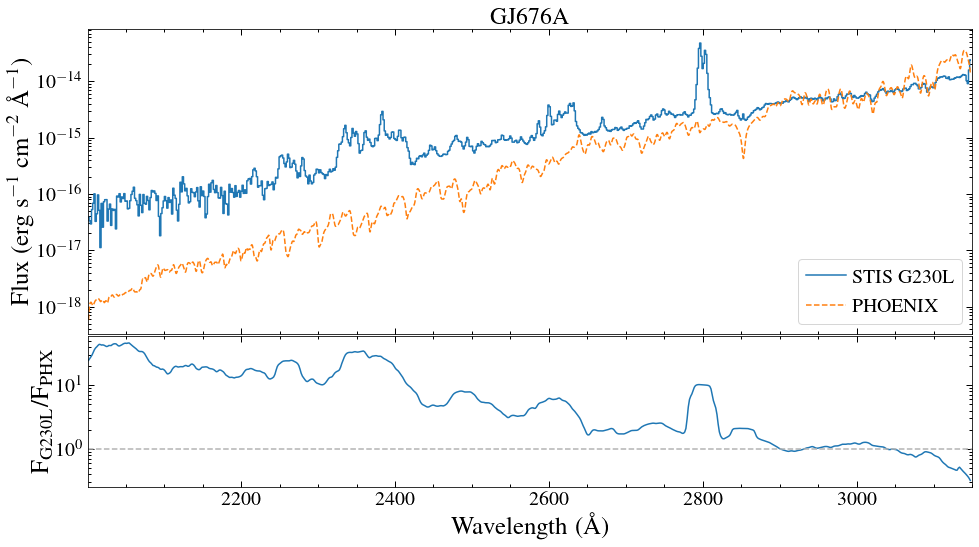

GJ649
747
69
632
0


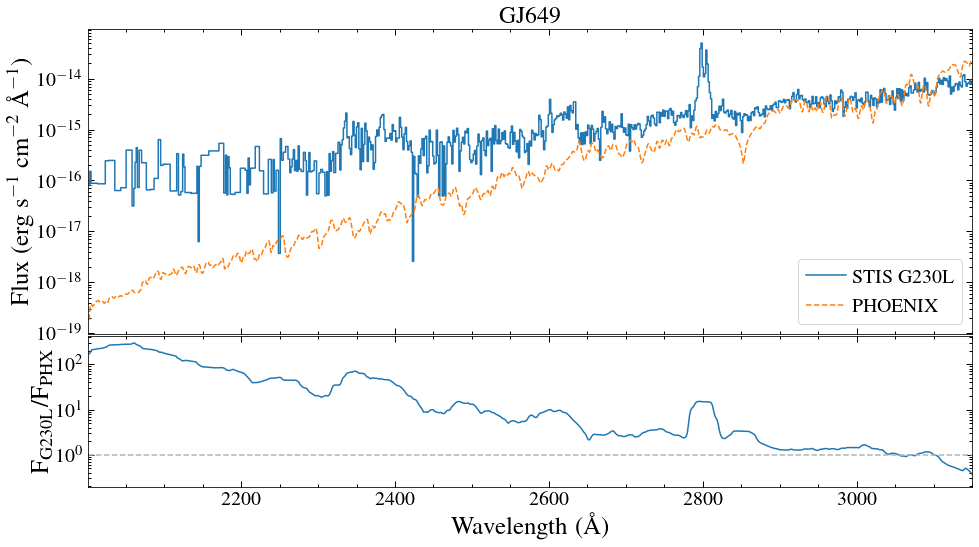

GJ699
746
129
538
0


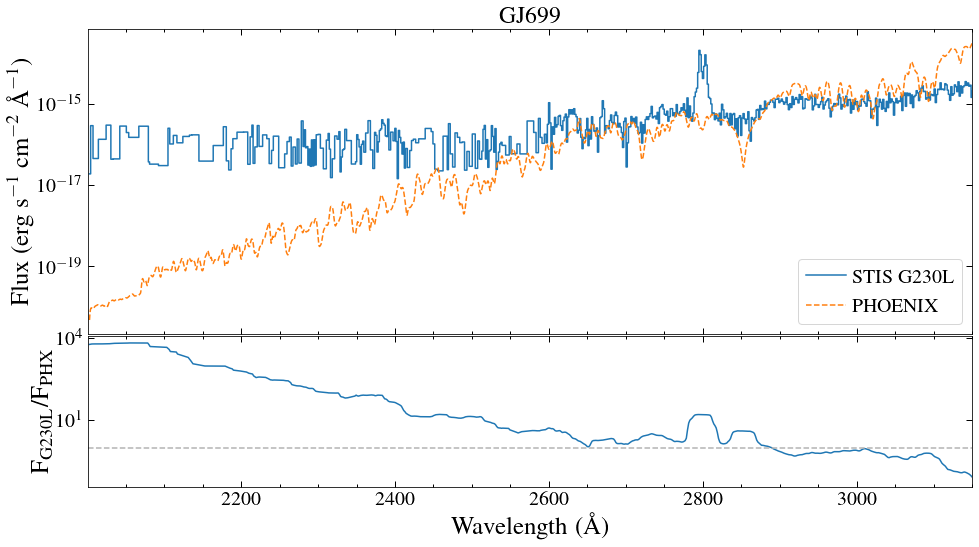

GJ163
742
95
576
0


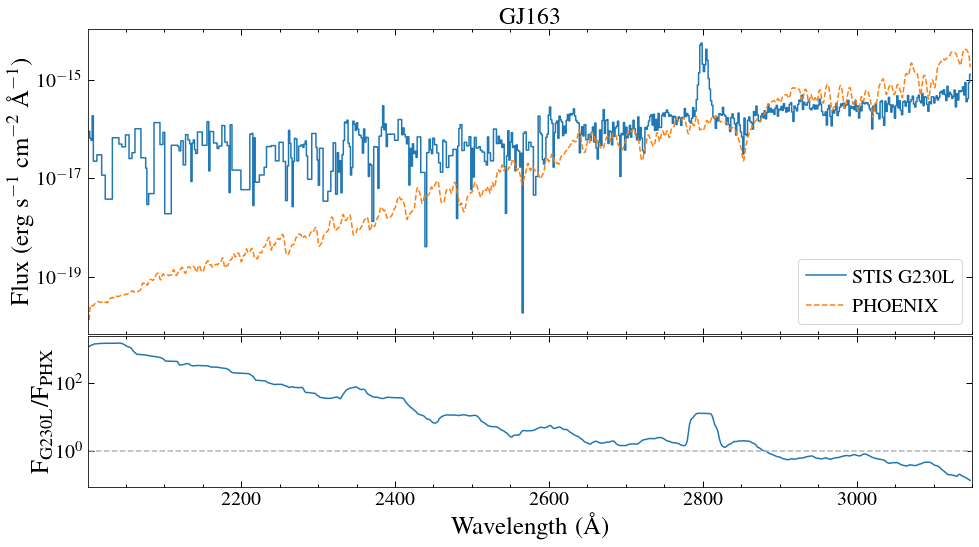

GJ849
743
92
598
0


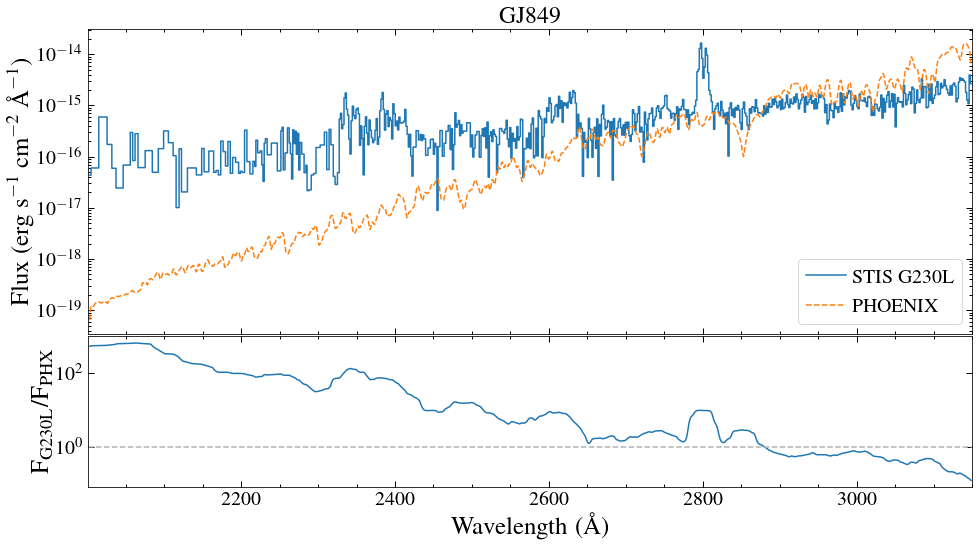

GJ1132
744
234
354
0


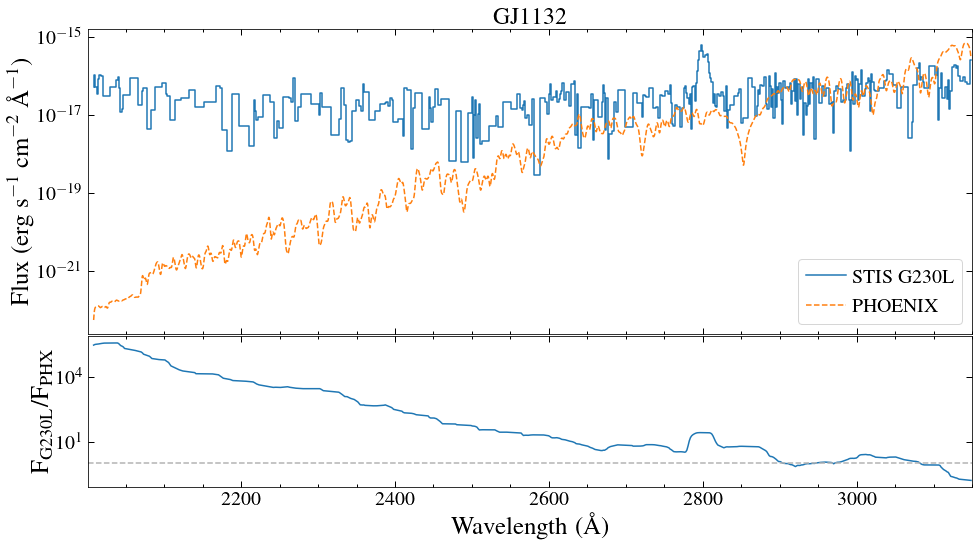

LHS-2686
741
28
690
0


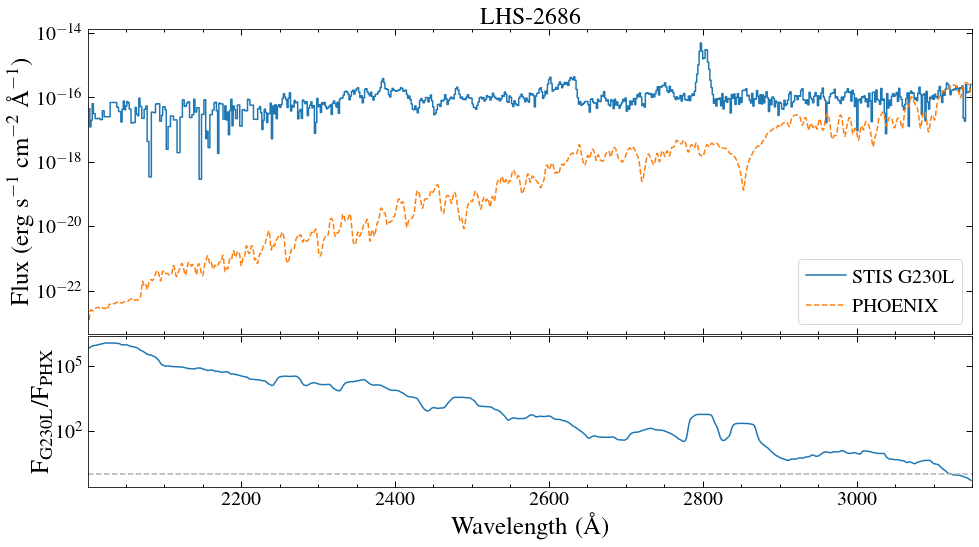

GJ729
777
238
369
0


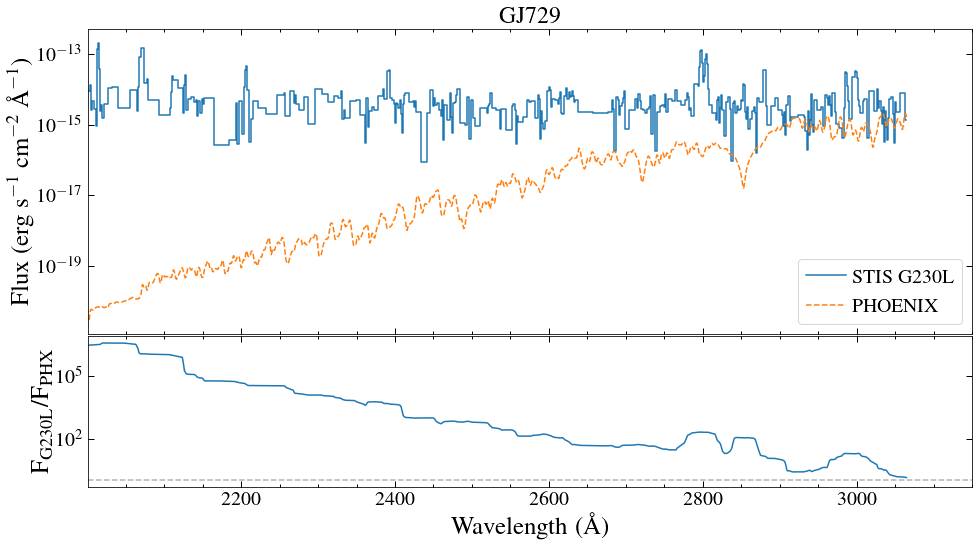

GJ15A
777
159
510
0


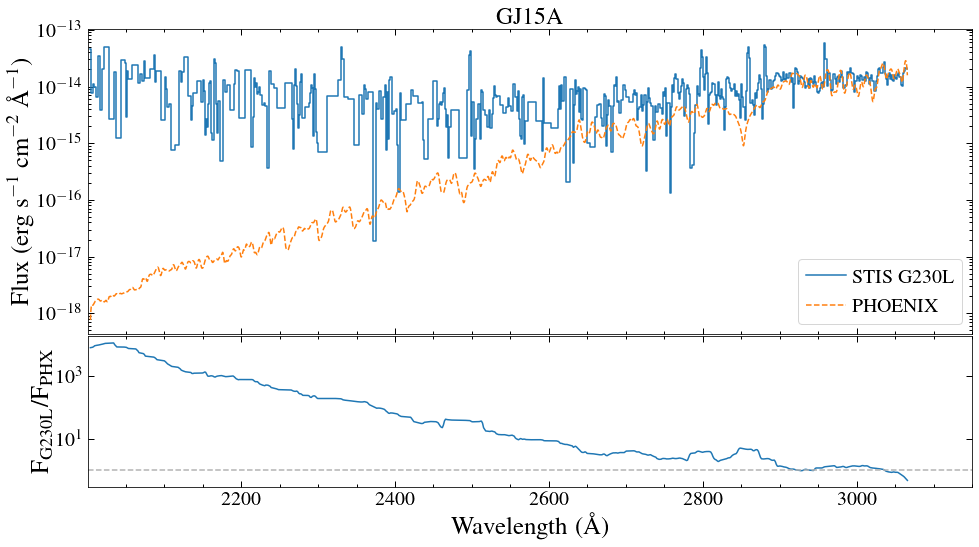

In [51]:
# xs = [2001, 3150]


# for star in stars:
#     fig = plt.figure(figsize=(14, 8))
#     gs = GridSpec(6,1, figure=fig)
#     ax = plt.subplot(gs[:4])


#     phxpath = glob.glob('{}{}/components_v1/*phx*.ecsv'.format(path,star))[0]
#     nuvpath = glob.glob('{}{}/components_v1/*230*.ecsv'.format(path, star))[0]
#     print(star)
    
#     ndata = Table.read(nuvpath)
#     nw, nf = ndata['WAVELENGTH'], ndata['FLUX']
#     nw, nf, ne = ndata['WAVELENGTH'], ndata['FLUX'], ndata['ERROR']
#     mask = nw > 2000
#     nw, nf, ne = nw[mask], nf[mask], ne[mask]
#     nw, nf, ne = remove_negatives(nw, nf, ne)
    
#     pdata = Table.read(phxpath)
#     pw, pf = pdata['WAVELENGTH'], pdata['FLUX']*pdata.meta['NORMFAC']
#     mask = (pw > nw[0]) & (pw < nw[-1])
#     pw, pf = pw[mask], pf[mask]
#     pw, pf = smear(pw, pf, 2000)
   
#     plt.step(nw, nf, where='mid', c='C0', label ='STIS G230L')

#     plt.plot(pw, pf, label='PHOENIX', ls='--', c='C1')
    

  
#     plt.yscale('log')
#     plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=25)

#     plt.xticks(visible=False)
#     plt.xlim(xs[0], xs[1])
#     plt.legend(loc=4, frameon=True)
#     plt.title(star)
    
    
#     plt.subplot(gs[4:])
#     pfi = interpolate.interp1d(pw, pf, fill_value='extrapolate')(nw)
#     ratio = convolve(nf/pfi, Box1DKernel(20))
#     plt.plot(nw, ratio)
    

#     plt.xlabel('Wavelength (\AA)', size=25)
#     plt.ylabel('F$_{\mathrm{G230L}}$/F$_{\mathrm{PHX}}$', size=25)
#    # plt.xlim(wo[0]-10, wo[-1]+10)
#     plt.axhline(1.0, ls='--', c='0.7')
#     plt.yscale('log')
# #     plt.xlim(3200, 5900)
# #     plt.ylim(1.3e-1, 0.7e1)
#     plt.xlim(xs[0], xs[1])
 
#     plt.tight_layout()
#     plt.subplots_adjust(hspace=0.03)
#     plt.savefig('plots/nuv_v_phx/{}_nuv.pdf'.format(star), dpi=300)
#     plt.savefig('plots/nuv_v_phx/{}_nuv.png'.format(star), dpi=300)

    
#     plt.show()

L-980-5
4052.396625
1021
288


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


554
0


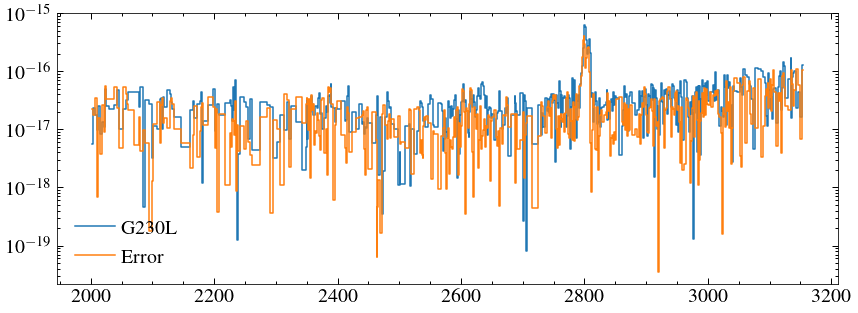

GJ674
70.0175
1024
199


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


713
0


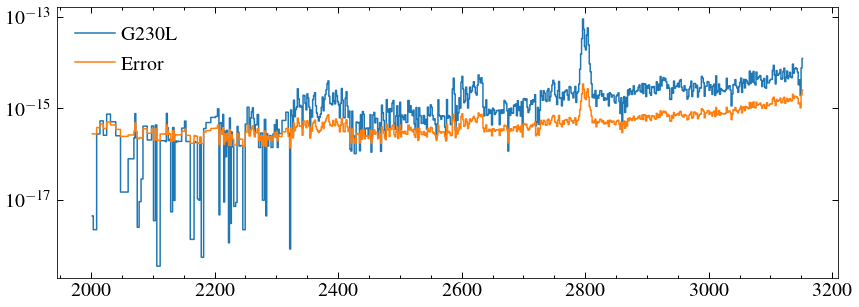

GJ676A
3998.399375
1021
57


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


927
0


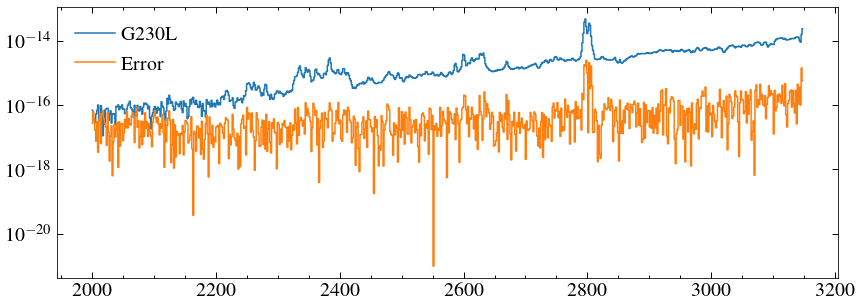

GJ649
100.019
1024
191


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


723
0


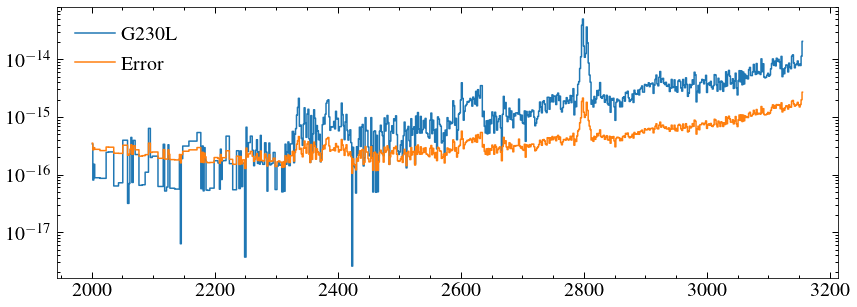

GJ699
200.01875
1024
267


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


603
0


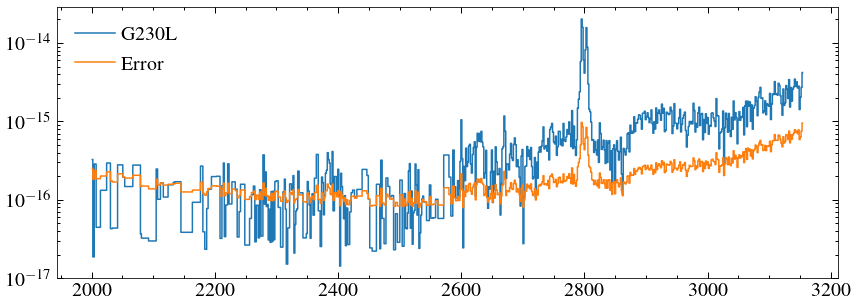

GJ163
1556.199375
1024
232


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


651
0


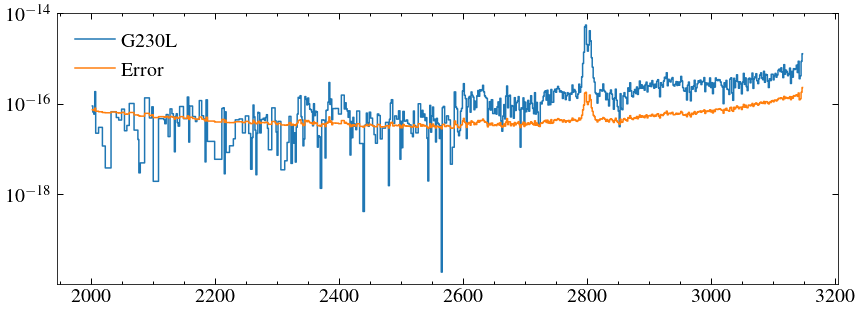

GJ849
154.018125
1024
240


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


660
0


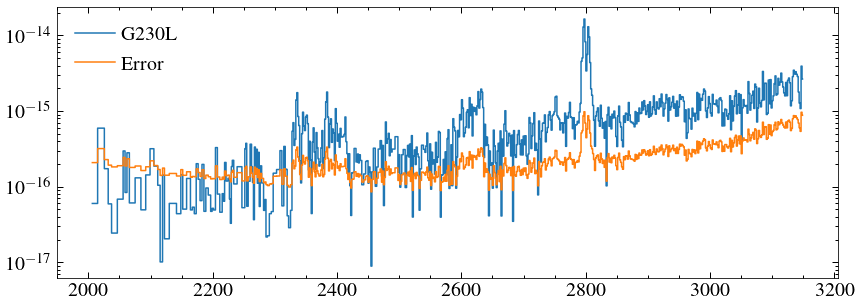

GJ1132
2603.19675
1024
362


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


438
0


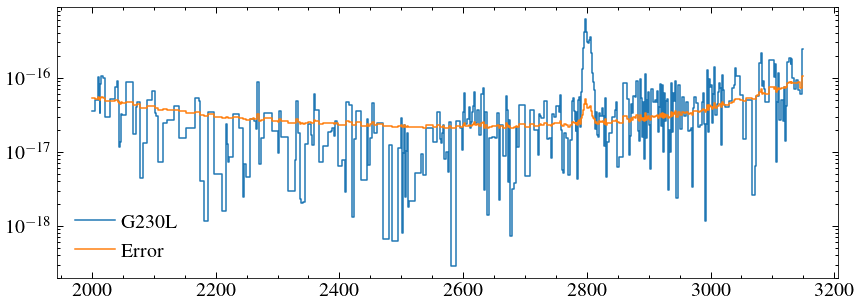

LHS-2686
2522.396125
1021
120


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


824
0


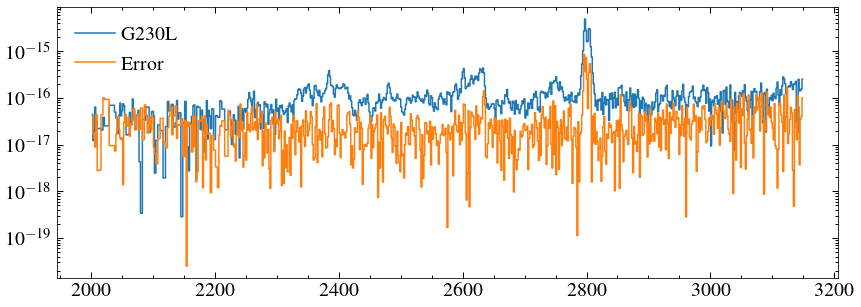

GJ729
80.0
1023
352


/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/david/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/lib/function_base.py:425: RuntimeWarning: invalid value encountered in multiply
  avg = np.multiply(a, wgt, dtype=result_dtype).sum(axis)/scl


439
0


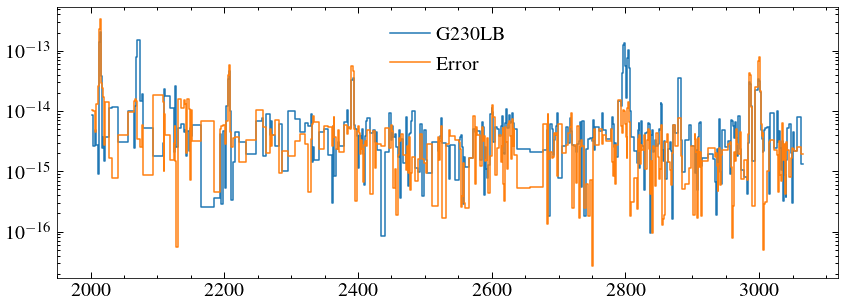

GJ15A
60.0
1023
255
599
0


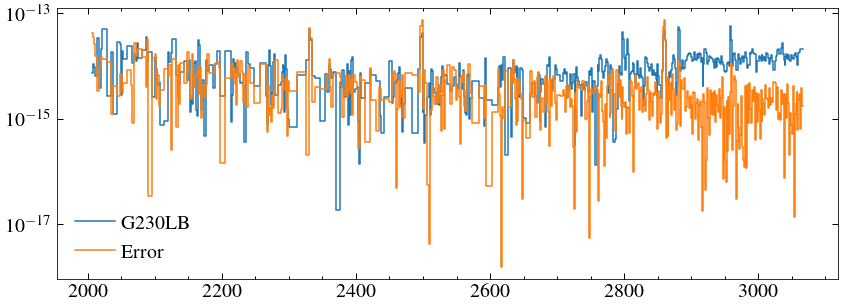

In [62]:
for star in stars:
#     phxpath = glob.glob('{}{}/components_v1/*phx*.ecsv'.format(path,star))[0]
    nuvpath = glob.glob('{}{}/components_v1/*230*.ecsv'.format(path, star))[0]
    print(star)
#     pdata = Table.read(phxpath)
#     pw, pf = pdata['WAVELENGTH'], pdata['FLUX']*pdata.meta['NORMFAC']
#     mask = (pw > 1500) & (pw < 3200)
#     pw, pf = pw[mask], pf[mask]
#     plt.plot(pw, pf)
    
    ndata = Table.read(nuvpath)
    print(ndata['EXPTIME'][100])
    nw, nf, ne = ndata['WAVELENGTH'], ndata['FLUX'], ndata['ERROR']
    nw, nf, ne = remove_negatives(nw, nf, ne)
    mask = (nw > 2000)
    nw, nf, ne = nw[mask], nf[mask], ne[mask]
#     mask = (pw > 1500) & (pw < 3000)
#     pw, pf = pw[mask], pf[mask]
    plt.step(nw, nf, where='mid', label = ndata.meta['GRATING'] )
    plt.step(nw, ne, where='mid', label='Error')
    plt.yscale('log')
    plt.legend()
    plt.show()

L-980-5
744
158
473
0


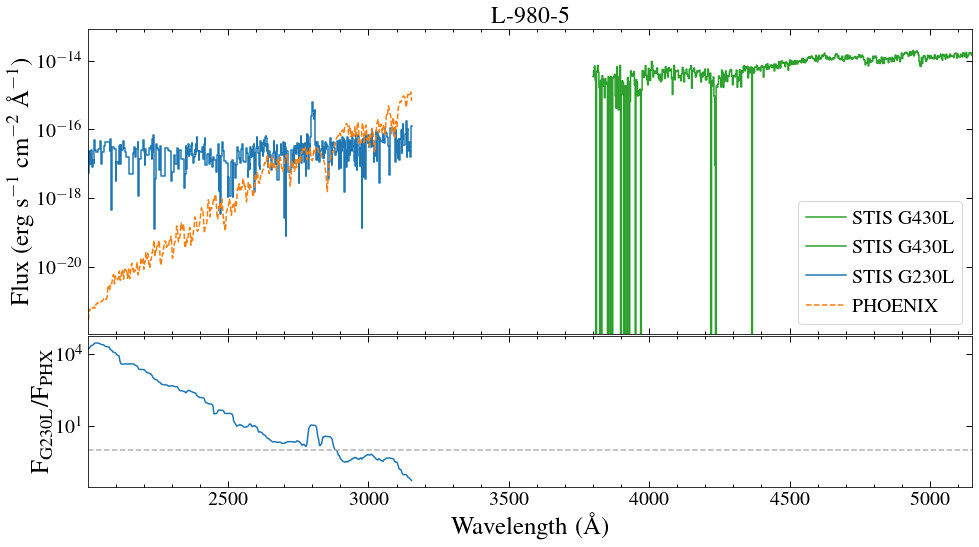

In [63]:
xs = [2001, 5150]


for star in stars[0:1]:
    fig = plt.figure(figsize=(14, 8))
    gs = GridSpec(6,1, figure=fig)
    ax = plt.subplot(gs[:4])


    phxpath = glob.glob('{}{}/components_v1/*phx*.ecsv'.format(path,star))[0]
    nuvpath = glob.glob('{}{}/components_v1/*230*.ecsv'.format(path, star))[0]
    optpath = glob.glob('{}{}/components_v1/*430l*.ecsv'.format(path, star))[0]
    print(star)
    
    ndata = Table.read(nuvpath)
    nw, nf, ne = ndata['WAVELENGTH'], ndata['FLUX'], ndata['ERROR']
    mask = nw > 2000
    nw, nf, ne = nw[mask], nf[mask], ne[mask]
    nw, nf, ne = remove_negatives(nw, nf, ne)
    
    odata = Table.read(optpath)
    ow, of, oe = odata['WAVELENGTH'], odata['FLUX'], odata['ERROR']
    mask = ow > 3800
    ow, of, oe = ow[mask], of[mask], oe[mask]
    plt.step(ow, of, oe, where='mid', c='C2', label='STIS G430L')
    
    pdata = Table.read(phxpath)
    pw, pf = pdata['WAVELENGTH'], pdata['FLUX']*pdata.meta['NORMFAC']
    mask = (pw > nw[0]) & (pw < nw[-1])
    pw, pf = pw[mask], pf[mask]
    pw, pf = smear(pw, pf, 2000)
   
    plt.step(nw, nf, where='mid', c='C0', label ='STIS G230L')

    plt.plot(pw, pf, label='PHOENIX', ls='--', c='C1')
    

  
    plt.yscale('log')
    plt.ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)', size=25)

    plt.xticks(visible=False)
    plt.xlim(xs[0], xs[1])
    plt.legend(loc=4, frameon=True)
    plt.title(star)
    
    
    plt.subplot(gs[4:])
    pfi = interpolate.interp1d(pw, pf, fill_value='extrapolate')(nw)
    ratio = convolve(nf/pfi, Box1DKernel(20))
    plt.plot(nw, ratio)
    

    plt.xlabel('Wavelength (\AA)', size=25)
    plt.ylabel('F$_{\mathrm{G230L}}$/F$_{\mathrm{PHX}}$', size=25)
   # plt.xlim(wo[0]-10, wo[-1]+10)
    plt.axhline(1.0, ls='--', c='0.7')
    plt.yscale('log')
#     plt.xlim(3200, 5900)
#     plt.ylim(1.3e-1, 0.7e1)
    plt.xlim(xs[0], xs[1])
 
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.03)
    plt.savefig('plots/nuv_v_phx/{}_nuv.pdf'.format(star), dpi=300)
    plt.savefig('plots/nuv_v_phx/{}_nuv.png'.format(star), dpi=300)

    
    plt.show()